In [21]:
# ipython
%matplotlib inline

from IPython.display import display as d
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("white")
import glob
import json
import os
import sys
import json
import os
import sys
import multiprocessing
pool = multiprocessing.Pool(multiprocessing.cpu_count())

os.makedirs("figures", exist_ok=True)
def save_fig(ax, fn):
    ax.get_figure().savefig(f"figures/{fn}.pdf", bbox_inches="tight")

In [22]:
import sqlite3
conn = sqlite3.connect('ratings.db')

tables = ["info", "ratings", "user_playlist"]

df = pd.read_sql_query("SELECT * from ratings", conn)
dinfo = pd.read_sql_query("SELECT * from info", conn)
dpl = pd.read_sql_query("SELECT * from user_playlist", conn)


d(dinfo.head())
d(dpl.head())
d(df.head())
print(len(df))

,user_ID,info_json
0,1,"{""userAgeRange"": ""30 to 39"", ""userGender"": ""Ma..."
1,4,"{""userAgeRange"": ""30 to 39"", ""userGender"": ""Ma..."
2,5,"{""userAgeRange"": ""25 to 29"", ""userGender"": ""Ma..."
3,6,"{""userAgeRange"": ""25 to 29"", ""userGender"": ""Ma..."
4,62,"{""userAgeRange"": ""25 to 29"", ""userGender"": ""Fe..."


,user_ID,playlist,timestamp
0,1,"[688, 309, 152, 1161, 1011, 1267, 757, 441, 11...",2020-03-27 13:50:53 566703
1,2,"[956, 589, 1082, 650, 657, 807, 596, 970, 1023...",2020-03-27 13:35:00 968899
2,3,"[468, 313, 1210, 1287, 996, 271, 1149, 439, 81...",2020-03-27 14:14:14 643751
3,4,"[476, 912, 42, 1258, 732, 308, 1155, 1079, 410...",2020-03-27 14:55:32 195248
4,5,"[358, 1385, 786, 777, 902, 644, 1002, 1183, 14...",2020-03-27 16:06:05 479548


,user_ID,stimuli_ID,stimuli_file,rating_type,rating,timestamp
0,1,-1,,user_registered,-1,2020-03-27 13:50:53 566942
1,1,688,./images/Sparks_20170214.mxf_1frame_crf_06_hei...,acr,2,2020-03-27 13:51:10 959845
2,1,309,./images/NTIA_4K_Vignette_1_Violin-422p-8bit-6...,acr,1,2020-03-27 13:51:14 468659
3,1,152,./images/classroom.mkv_1frame_crf_12_height_03...,acr,2,2020-03-27 13:51:18 371806
4,1,1161,./images/asian_fusion_harmonic.mkv_1frame_crf_...,acr,1,2020-03-27 13:51:21 653894


15899


In [23]:
users_who_rated = set(pd.read_sql_query("select distinct(user_id) from ratings where rating <> -1", conn)["user_ID"].values)
print(len(users_who_rated))
print(users_who_rated)

146
{1, 4, 5, 6, 7, 62, 65, 82, 89, 106, 110, 111, 112, 113, 114, 115, 116, 117, 118, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131, 133, 135, 136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 239, 241, 242, 243, 244, 245, 246, 249, 250, 251, 252, 253, 255, 256, 257, 259, 260, 261, 263, 265, 266}


In [24]:
import matplotlib.pyplot as plt

def extract_info(x):
    return pd.Series(json.loads(x))

dinfo["rated"] = dinfo["user_ID"].apply(lambda x: x in users_who_rated)
dinfo = dinfo[dinfo["rated"]] 

di = pd.DataFrame(dinfo["info_json"].apply(extract_info))
di = di[di.columns.difference(["userGender"])]


def estimate_os(x):
    if "Windows" in x:
        return "Win"
    if "Apple" in x or "Mac" in x:
        return "MacOS"
    if "Linux" in x:
        return "Linux"
    return "other"

di["os"] = di["browser_agent"].apply(estimate_os)

di["screen_size"] = di["screen_size"].apply(lambda x: -1 if x == "" else int(x.split("x")[1]))

print(di.head())

                                       browser_agent  screen_size  \
0  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...          722   
1  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...          722   
2  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...         1298   
3  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...          937   
4  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...          722   

  userAgeRange userComputerType userEyeQuality              userRoomQuality  \
0     30 to 39           Laptop        Good(4)  Some Noise and Distractions   
1     30 to 39           Laptop   Excellent(5)        Alone in a Quiet Room   
2     25 to 29          Desktop   Excellent(5)        Alone in a Quiet Room   
3     25 to 29          Desktop   Excellent(5)        Alone in a Quiet Room   
4     25 to 29           Laptop        Good(4)        Alone in a Quiet Room   

      os  
0  MacOS  
1    Win  
2    Win  
3    Win  
4    Win  


145


,browser_agent,screen_size,userAgeRange,userComputerType,userEyeQuality,userRoomQuality,os
0,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,722,30 to 39,Laptop,Good(4),Some Noise and Distractions,MacOS
1,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,722,30 to 39,Laptop,Excellent(5),Alone in a Quiet Room,Win
2,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1298,25 to 29,Desktop,Excellent(5),Alone in a Quiet Room,Win
3,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,937,25 to 29,Desktop,Excellent(5),Alone in a Quiet Room,Win
4,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,722,25 to 29,Laptop,Good(4),Alone in a Quiet Room,Win


browser_agent
os
screen_size
userAgeRange
userComputerType
userEyeQuality
userRoomQuality


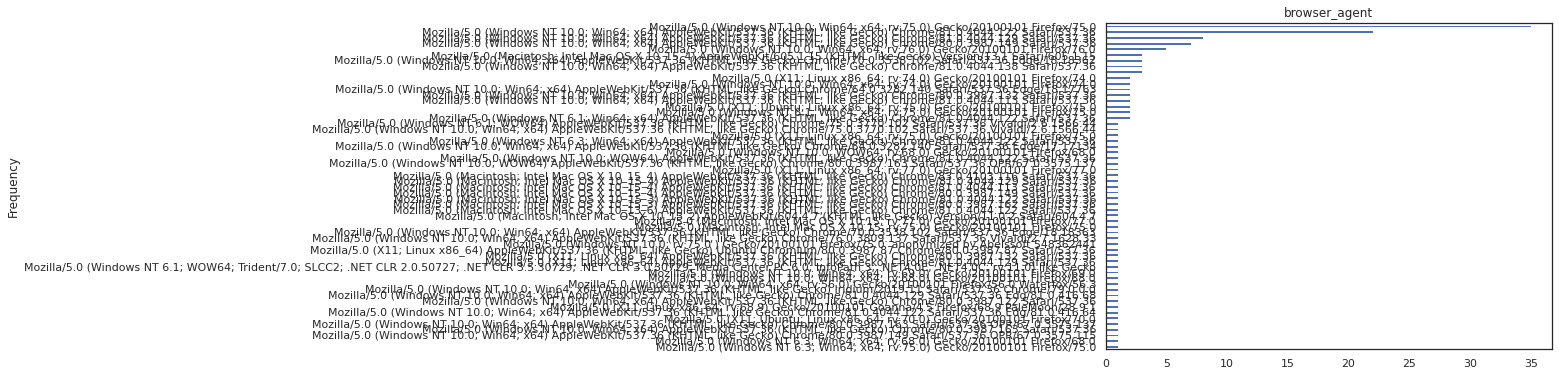

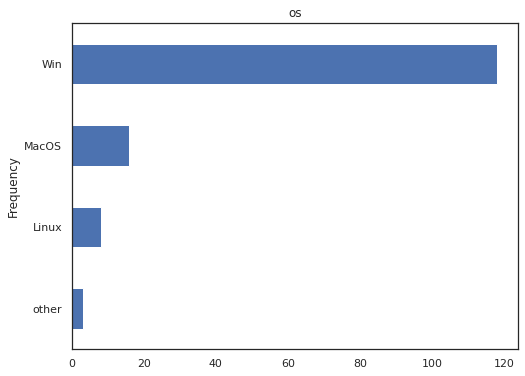

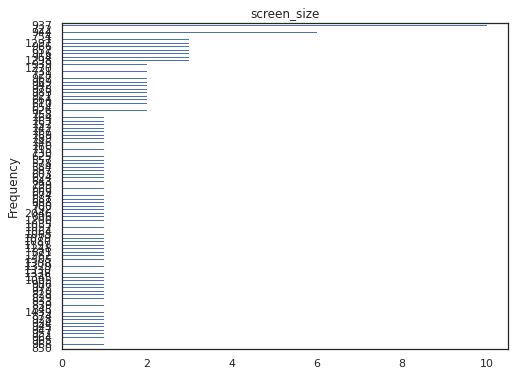

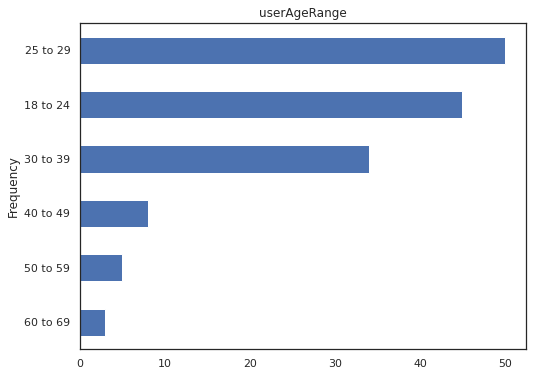

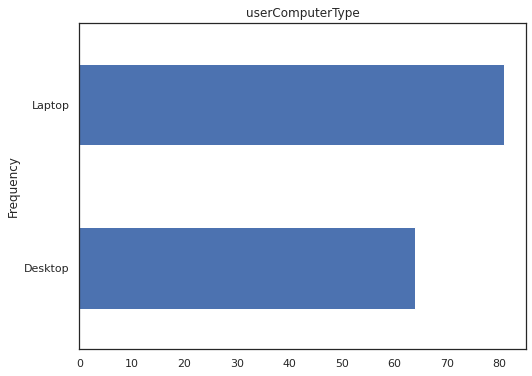

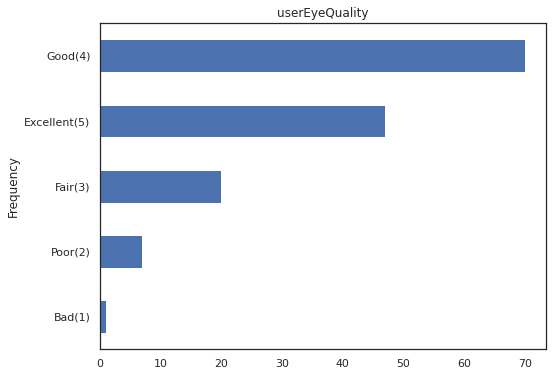

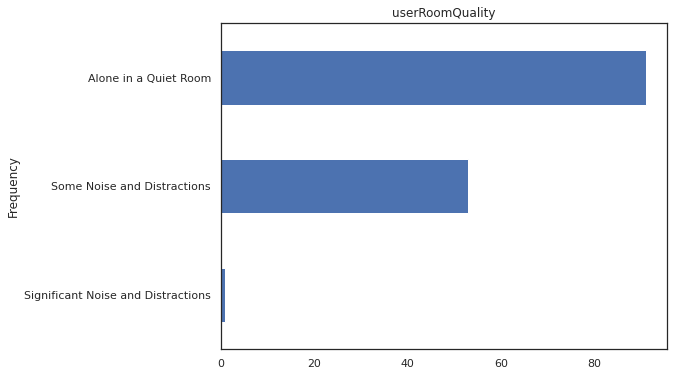

In [25]:

print(len(di))
d(di.head())
di["c"] = 1
for c in di.columns.difference(["c"]):
    print(c)
    gg = di.groupby(by=c).count().reset_index()[[c, "c"]]
    gg = gg.sort_values(by="c")
    ax = gg.plot(x=c, y="c", kind="barh", legend=False, figsize=(8,6))
    ax.set_title(c)
    ax.set_ylabel("Frequency")
    save_fig(ax, "user_" + c)

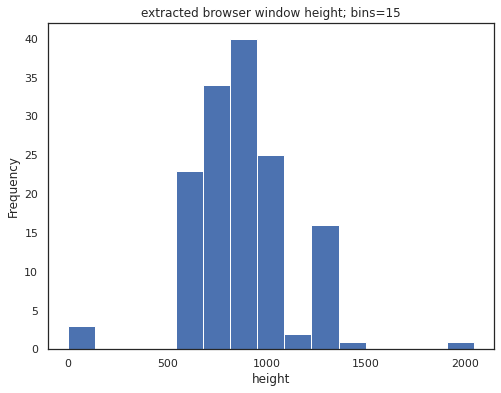

In [27]:

ax = di["screen_size"].plot(kind="hist", bins=15)
ax.set_xlabel("height")
ax.set_title(f"extracted browser window height; bins=15")

save_fig(ax, "user_windowheight")

,user_ID,stimuli_ID,stimuli_file,rating_type,rating,timestamp
0,1,-1,,user_registered,-1,2020-03-27 13:50:53 566942
1,1,688,./images/Sparks_20170214.mxf_1frame_crf_06_hei...,acr,2,2020-03-27 13:51:10 959845
2,1,309,./images/NTIA_4K_Vignette_1_Violin-422p-8bit-6...,acr,1,2020-03-27 13:51:14 468659
3,1,152,./images/classroom.mkv_1frame_crf_12_height_03...,acr,2,2020-03-27 13:51:18 371806
4,1,1161,./images/asian_fusion_harmonic.mkv_1frame_crf_...,acr,1,2020-03-27 13:51:21 653894


15899 15534 365


<ipython-input-28-77fb36171f4e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr["c"] = 1


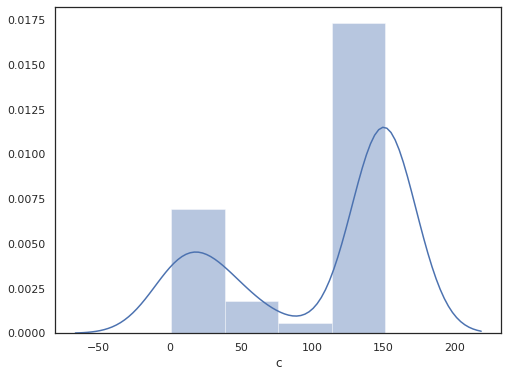

In [28]:
d(df.head())
df["rating"] = df["rating"].astype(np.int)
# select pure ratings
dr = df[df["rating"] > 0]
print(
    len(df),
    len(dr),
    len(df) - len(dr)
)

dr["c"] = 1
sns.distplot(dr.groupby(by="user_ID").count().reset_index()["c"])

In [44]:
h = {}
for x in dr.groupby(by=["stimuli_ID"]).count().reset_index()["c"].values:
    h[x] = h.get(x, 0) + 1
print(h)
print(h[10], h[11])

mm = 0
for i in range(10, 100):
    mm += h.get(i, 0)
print(mm)


mm = 0
for i in range(0, 10):
    mm += h.get(i, 0)
print(mm)

print(h[1])
print(h[2])

{4: 20, 15: 48, 11: 191, 13: 136, 12: 149, 9: 193, 10: 197, 7: 109, 17: 20, 8: 135, 5: 40, 14: 88, 16: 45, 6: 66, 20: 8, 3: 11, 18: 11, 19: 7, 21: 4, 2: 4, 22: 1, 1: 1}
197 191
905
579
1
4


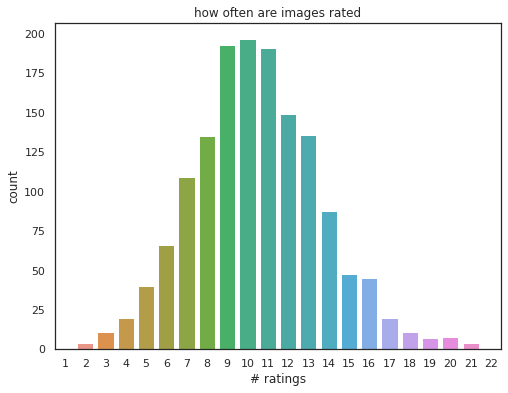

In [31]:
ax = sns.countplot(dr.groupby(by=["stimuli_ID"]).count().reset_index()["c"])
ax.set_xlabel("# ratings")
ax.set_title("how often are images rated")
save_fig(ax, "how_often_rated")

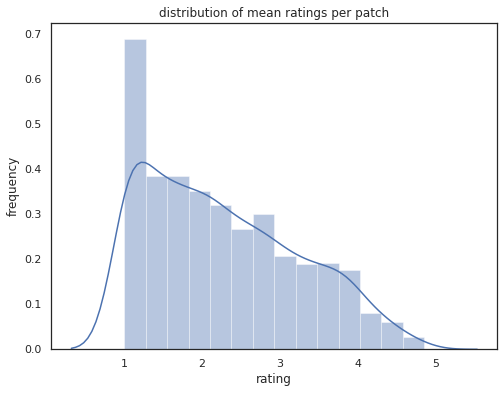

In [52]:
ax = sns.distplot(dr.groupby(by=["stimuli_ID"]).mean().reset_index()["rating"])

ax.set_title("distribution of mean ratings per patch")
ax.set_ylabel("frequency")
save_fig(ax, "dist_rating_patches")

In [53]:
dmos = pd.read_csv("../test_1/mos_ci.csv")
d(dmos.head())
print(len(dmos))
dr["image_name"] = dr["stimuli_file"].apply(lambda x: "_".join(os.path.basename(x).split("_")[0:-1])).copy()

dmean_r = dr.groupby(by="image_name").mean().reset_index()[["image_name", "rating"]]
dmean_r = dmean_r.rename(columns={"rating": "mean_crowd"})
print(len(dmean_r), len(dr))

d(dmean_r.head())

dmerged = pd.merge(dmos, dmean_r)
d(dmerged.head())

,image_name,mos,ci
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762,0.568885
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524,0.547677
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190,0.547677
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857,0.435249


371
371 15534


<ipython-input-53-f262258dfb6e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr["image_name"] = dr["stimuli_file"].apply(lambda x: "_".join(os.path.basename(x).split("_")[0:-1])).copy()


,image_name,mean_crowd
0,BennuProRes4444.mov_1frame_crf_03_height_0864,2.885714
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.585366
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.435897
3,BennuProRes4444.mov_1frame_crf_13_height_0304,1.980392
4,BennuProRes4444.mov_1frame_crf_21_height_0320,1.709677


,image_name,mos,ci,mean_crowd
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565,2.885714
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762,0.568885,2.585366
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524,0.547677,2.435897
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190,0.547677,1.980392
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857,0.435249,1.709677


0.96

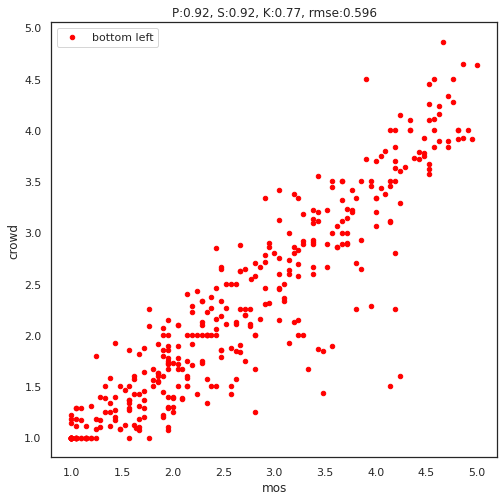

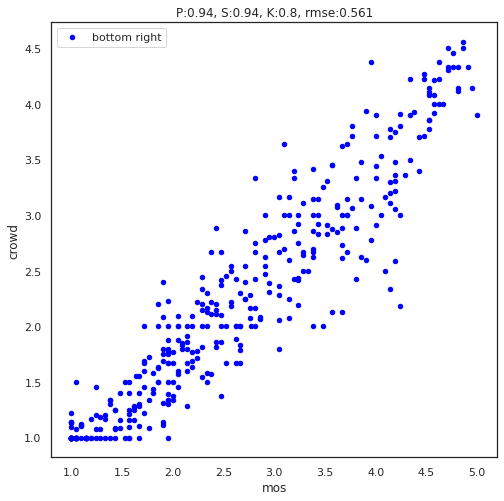

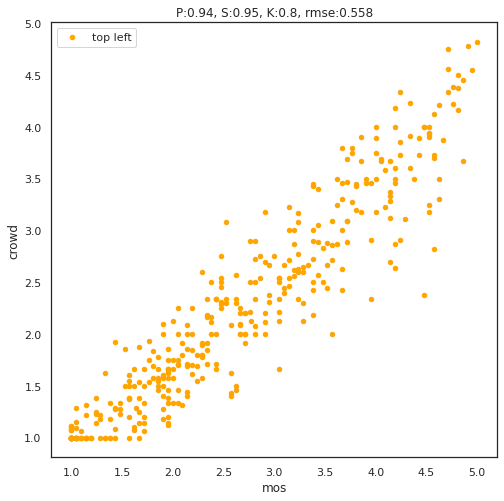

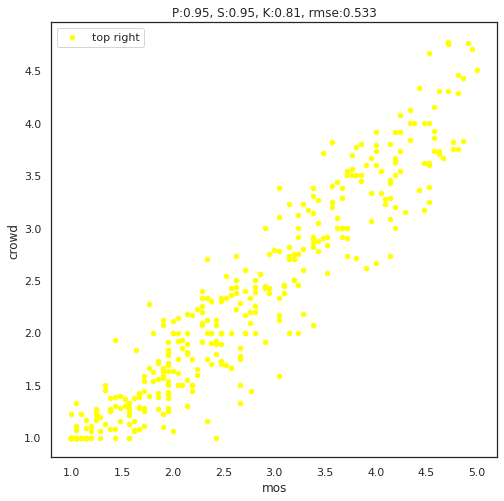

In [77]:
dr["patch"] = dr["stimuli_file"].apply(lambda x: x.split("_")[-1].split(".")[0])
dr = dr.rename(columns={
    "rating": "crowd"
})

#d(dr.head())
cmap = {
    "bl": "red", 
    "br": "blue", 
    "tl": "orange", 
    "tr": "yellow"
}
ax = None
label_map = {
    "bl": "bottom left", 
    "br": "bottom right", 
    "tl": "top left", 
    "tr": "top right"
}
sns.set_style("white")
vvv = []
corrs = []
for i, g in dr.groupby(by="patch"):
    dgg = pd.merge(g, dmos).groupby(by="image_name").mean()
    #print(i)
    #print(len(dgg))
    #d(dgg.head())
    rmse = ((dgg["mos"] - dgg["crowd"]) ** 2).mean() ** .5 
    corr = "P:{}, S:{}, K:{}, rmse:{}".format(
        dgg[["mos", "crowd"]].corr(method="pearson")["mos"][1].round(2),
        dgg[["mos", "crowd"]].corr(method="spearman")["mos"][1].round(2),
        dgg[["mos", "crowd"]].corr(method="kendall")["mos"][1].round(2),
        rmse.round(3)
    )

    ax = dgg.plot(x="mos", y="crowd", kind="scatter", figsize=(8,8), title=corr, c=cmap[i], label=label_map[i])
    
    vvv.append(dgg.copy())
    
    corrs.append(
        {
            "patch": label_map[i],
            "pearson": dgg[["mos", "crowd"]].corr(method="pearson")["mos"][1],
            "kendall": dgg[["mos", "crowd"]].corr(method="spearman")["mos"][1],
            "spearman": dgg[["mos", "crowd"]].corr(method="kendall")["mos"][1],
            "rmse": rmse
        }
    )
    #break

d(((vvv[-2] + vvv[-1])/ 2)[["mos", "crowd"]].corr(method="pearson")["mos"][1].round(2))

,stimuli_file,user_ID,crowd,c,patch,image_name,mos,ci
0,./images/BennuProRes4444.mov_1frame_crf_03_hei...,179.333333,2.500000,1.0,bottom left,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565
1,./images/BennuProRes4444.mov_1frame_crf_03_hei...,190.727273,3.636364,1.0,bottom right,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565
2,./images/BennuProRes4444.mov_1frame_crf_03_hei...,166.888889,2.666667,1.0,top left,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565
3,./images/BennuProRes4444.mov_1frame_crf_03_hei...,195.222222,2.444444,1.0,top right,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565
4,./images/BennuProRes4444.mov_1frame_crf_06_hei...,190.846154,2.461538,1.0,bottom left,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762,0.568885
...,...,...,...,...,...,...,...,...
1479,./images/weapon8k-standard-60fps-12to1redcode_...,191.400000,1.500000,1.0,top right,weapon8k-standard-60fps-12to1redcode_16x9_444....,1.952381,0.609090
1480,./images/weapon8k-standard-60fps-12to1redcode_...,206.444444,1.222222,1.0,bottom left,weapon8k-standard-60fps-12to1redcode_16x9_444....,1.000000,NaN
1481,./images/weapon8k-standard-60fps-12to1redcode_...,162.285714,1.142857,1.0,bottom right,weapon8k-standard-60fps-12to1redcode_16x9_444....,1.000000,NaN
1482,./images/weapon8k-standard-60fps-12to1redcode_...,134.384615,1.076923,1.0,top left,weapon8k-standard-60fps-12to1redcode_16x9_444....,1.000000,NaN


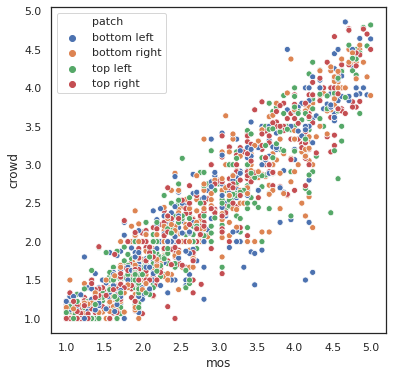

In [81]:
ddd = dr.groupby(by="stimuli_file").mean().reset_index()

ddd["patch"] = ddd["stimuli_file"].apply(lambda x: x.split("_")[-1].split(".")[0])
ddd["patch"] = ddd["patch"].apply(lambda x: label_map[x])
ddd["image_name"] = ddd["stimuli_file"].apply(lambda x: "_".join(os.path.basename(x).split("_")[0:-1])).copy()

ddd = pd.merge(ddd, dmos)

d(ddd)

sns.set(rc={'figure.figsize':(6,6)})
sns.set_style("white")
ax = sns.scatterplot(x="mos", y="crowd", data=ddd, hue="patch")
save_fig(ax, "scatter_per_patch")

In [83]:
dcorrs = pd.DataFrame(corrs)
d(dcorrs.sort_values(by="pearson", ascending=False))
print(dcorrs.sort_values(by="pearson", ascending=False).round(3).to_latex(index=False))

,patch,pearson,kendall,spearman,rmse
3,top right,0.947082,0.949040,0.814131,0.532938
2,top left,0.939049,0.945594,0.802540,0.558139
1,bottom right,0.937890,0.942027,0.800143,0.560991
0,bottom left,0.918271,0.918315,0.771154,0.596035


\begin{tabular}{lrrrr}
\toprule
        patch &  pearson &  kendall &  spearman &   rmse \\
\midrule
    top right &    0.947 &    0.949 &     0.814 &  0.533 \\
     top left &    0.939 &    0.946 &     0.803 &  0.558 \\
 bottom right &    0.938 &    0.942 &     0.800 &  0.561 \\
  bottom left &    0.918 &    0.918 &     0.771 &  0.596 \\
\bottomrule
\end{tabular}



In [92]:

sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("white")

In [85]:
dvar_r = dr.groupby(by="image_name").std().reset_index()[["image_name", "rating"]]
dvar_r = dvar_r.rename(columns={"rating": "std_crowd"})
d(dvar_r.head())

sns.distplot(dvar_r["std_crowd"])

KeyError: "['rating'] not in index"

In [86]:


dvar_r_pp = dr.groupby(by="stimuli_file").std().reset_index()[["stimuli_file", "rating"]]
dvar_r_pp = dvar_r_pp.rename(columns={"rating": "std_crowd_per_patch"})
d(dvar_r_pp.head())

sns.distplot(dvar_r_pp["std_crowd_per_patch"])

KeyError: "['rating'] not in index"

In [87]:
v = []
for i,g in dr.groupby(by="image_name"):
    #print(i)
    at_least_24 = 1
    at_least_12 = 1
    at_least_10 = 1
    at_least_5 = 1
    k = 0
    patch_count = {}
    for j, gg in g.groupby(by="stimuli_file"):
        #d(gg)
        patch_count[j.split("_")[-1].split(".")[0]] = len(gg)
        if len(gg) < 24:
            at_least_24 = 0
        
        if len(gg) < 12:
            at_least_12 = 0
        if len(gg) < 10:
            at_least_10 = 0
            
        if len(gg) < 5:
            at_least_5 = 0
        k += 1
    v.append(dict({
        "image": i, 
        "at_least_24": at_least_24, 
        "at_least_12": at_least_12, 
        "at_least_10": at_least_10, 
        "at_least_5": at_least_5, 
        "k": k
    }, **patch_count))


In [88]:
dv = pd.DataFrame(v)
d(dv.head())
d(dv[dv["at_least_24"] == 1])
d(dv[dv["at_least_12"] == 1])
d(dv[dv["at_least_10"] == 1])

print(

dv["at_least_10"].sum(),
    
dv["at_least_5"].sum()
)

,image,at_least_24,at_least_12,at_least_10,at_least_5,k,bl,br,tl,tr
0,BennuProRes4444.mov_1frame_crf_03_height_0864,0,0,0,1,4,6,11,9,9
1,BennuProRes4444.mov_1frame_crf_06_height_0592,0,0,0,1,4,13,9,10,9
2,BennuProRes4444.mov_1frame_crf_08_height_0448,0,0,0,0,4,8,3,12,16
3,BennuProRes4444.mov_1frame_crf_13_height_0304,0,0,0,1,4,14,8,18,11
4,BennuProRes4444.mov_1frame_crf_21_height_0320,0,0,0,0,4,11,10,9,1


,image,at_least_24,at_least_12,at_least_10,at_least_5,k,bl,br,tl,tr


,image,at_least_24,at_least_12,at_least_10,at_least_5,k,bl,br,tl,tr
20,Campfire_3840x2160_30fps_bt709_420_videoRange_...,0,1,1,1,4,12,14,12,12
56,DaylightRoad2_3840x2160_60fps_10bit_420_ffvhuf...,0,1,1,1,4,18,12,16,16
77,NETFLIX_ElFuente_4096x2160_28592frames_5994fps...,0,1,1,1,4,12,13,12,13
95,Netflix_BarScene_4096x2160_60fps_10bit_420.y4m...,0,1,1,1,4,12,12,13,14
102,Netflix_DinnerScene_4096x2160_60fps_10bit_420....,0,1,1,1,4,12,15,13,18
135,RollerCoaster_4096x2160_60fps_10bit_420_jvet_f...,0,1,1,1,4,15,12,14,15
176,TrafficFlow_3840x2160_30fps_10bit_420_jvet_ffv...,0,1,1,1,4,12,12,12,12
182,air_acrobatics_harmonic.mkv_1frame_crf_12_heig...,0,1,1,1,4,16,12,13,13
215,asian_fusion_harmonic.mkv_1frame_crf_17_height...,0,1,1,1,4,14,18,15,16
276,monkeys_harmonic.mkv_1frame_crf_02_height_1504,0,1,1,1,4,12,12,14,17


,image,at_least_24,at_least_12,at_least_10,at_least_5,k,bl,br,tl,tr
12,BuildingHall2_3840x2160_50fps_10bit_420_ffvhuf...,0,0,1,1,4,10,10,14,11
20,Campfire_3840x2160_30fps_bt709_420_videoRange_...,0,1,1,1,4,12,14,12,12
28,Campfire_3840x2160_30fps_bt709_420_videoRange_...,0,0,1,1,4,10,15,19,20
39,CatRobot_3840x2160_60fps_10bit_420_jvet_ffvhuf...,0,0,1,1,4,12,11,12,11
40,Dancers.avi_1frame_crf_00_height_1728,0,0,1,1,4,10,12,18,10
44,Dancers.avi_1frame_crf_09_height_0592,0,0,1,1,4,13,12,10,11
45,Dancers.avi_1frame_crf_21_height_0192,0,0,1,1,4,11,10,11,12
56,DaylightRoad2_3840x2160_60fps_10bit_420_ffvhuf...,0,1,1,1,4,18,12,16,16
58,DaylightRoad2_3840x2160_60fps_10bit_420_ffvhuf...,0,0,1,1,4,14,11,13,10
61,Drums_3840x2160_100fps_10bit_420_jvet_ffvhuff....,0,0,1,1,4,14,11,11,14


50 335


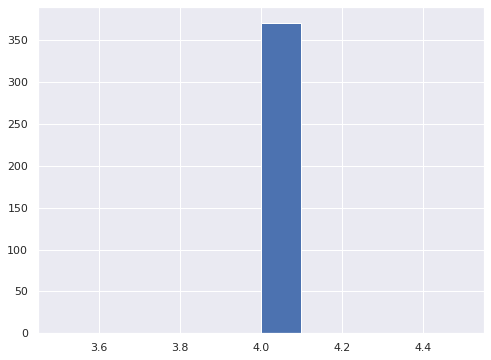

In [89]:
dv["k"].hist()

,image,at_least_24,at_least_12,at_least_10,at_least_5,k,bl,br,tl,tr
0,BennuProRes4444.mov_1frame_crf_03_height_0864,0,0,0,1,4,6,11,9,9
1,BennuProRes4444.mov_1frame_crf_06_height_0592,0,0,0,1,4,13,9,10,9
2,BennuProRes4444.mov_1frame_crf_08_height_0448,0,0,0,0,4,8,3,12,16
3,BennuProRes4444.mov_1frame_crf_13_height_0304,0,0,0,1,4,14,8,18,11
4,BennuProRes4444.mov_1frame_crf_21_height_0320,0,0,0,0,4,11,10,9,1


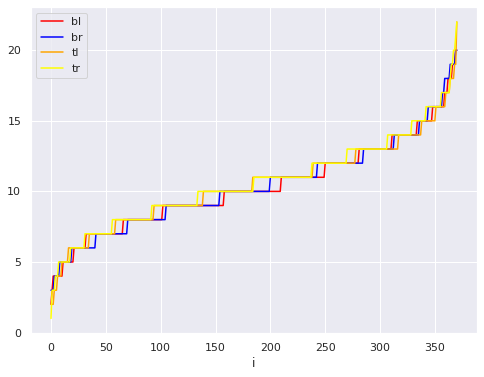

In [90]:
d(dv.head())

cmap = {
    "bl": "red", 
    "br": "blue", 
    "tl": "orange", 
    "tr": "yellow"
}
ax = None
for c in ["bl", "br", "tl", "tr"]:
    k = dv[[c, "image"]].sort_values(by=c).copy()
    k["i"] = range(len(k))
    
    ax = k.plot(x="i", y=c, kind="line", c=cmap[c], ax=ax)
    #break

,user_ID,stimuli_ID,stimuli_file,rating_type,crowd,timestamp,c,image_name,patch
1,1,688,./images/Sparks_20170214.mxf_1frame_crf_06_hei...,acr,2,2020-03-27 13:51:10 959845,1,Sparks_20170214.mxf_1frame_crf_06_height_0720,tr
2,1,309,./images/NTIA_4K_Vignette_1_Violin-422p-8bit-6...,acr,1,2020-03-27 13:51:14 468659,1,NTIA_4K_Vignette_1_Violin-422p-8bit-60fps-4096...,tr
3,1,152,./images/classroom.mkv_1frame_crf_12_height_03...,acr,2,2020-03-27 13:51:18 371806,1,classroom.mkv_1frame_crf_12_height_0368,bl
4,1,1161,./images/asian_fusion_harmonic.mkv_1frame_crf_...,acr,1,2020-03-27 13:51:21 653894,1,asian_fusion_harmonic.mkv_1frame_crf_08_height...,br
5,1,1011,./images/monkeys_harmonic.mkv_1frame_crf_02_he...,acr,4,2020-03-27 13:51:25 718980,1,monkeys_harmonic.mkv_1frame_crf_02_height_1504,br


,image_name,c,i
114,Netflix_DrivingPOV_4096x2160_60fps_10bit_420.y...,26,0
266,gooseberry.mkv_1frame_crf_19_height_0176,29,1
293,myanmar_harmonic.mkv_1frame_crf_21_height_0352,29,2
22,Campfire_3840x2160_30fps_bt709_420_videoRange_...,29,3
193,american_football_harmonic.mkv_1frame_crf_13_h...,29,4


Text(0, 0.5, '#ratings')

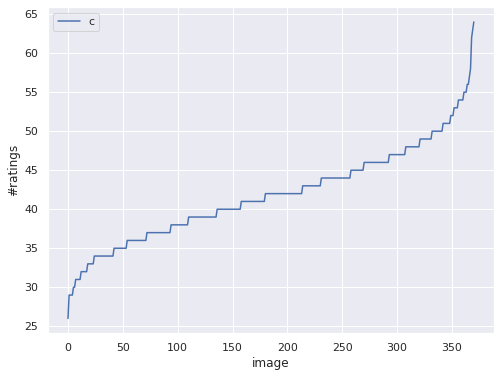

In [91]:
d(dr.head())
ddd = dr.groupby(by="image_name").count().reset_index()

ddd = ddd[["image_name", "c"]]
ddd = ddd.sort_values(by="c")
ddd["i"] = range(len(ddd))

d(ddd.head())
ax = ddd.plot(x="i", y="c", kind="line")
ax.set_xlabel("image")
ax.set_ylabel("#ratings")


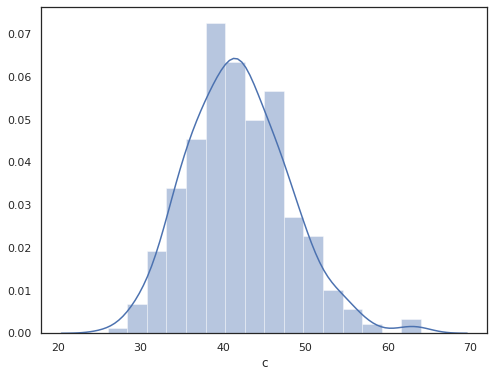

In [93]:
sns.distplot(dr.groupby("image_name").count().reset_index()["c"])

In [94]:
d(dmerged.head())
print(len(dmerged))

,image_name,mos,ci,mean_crowd
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565,2.885714
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762,0.568885,2.585366
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524,0.547677,2.435897
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190,0.547677,1.980392
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857,0.435249,1.709677


371


In [101]:
dmerged["mos"].max()

5.0

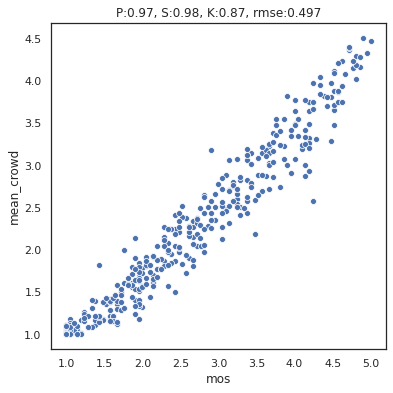

In [99]:
rmse = ((dmerged["mos"] - dmerged["mean_crowd"]) ** 2).mean() ** .5 
corr = "P:{}, S:{}, K:{}, rmse:{}".format(
    dmerged[["mos", "mean_crowd"]].corr(method="pearson")["mos"][1].round(2),
    dmerged[["mos", "mean_crowd"]].corr(method="spearman")["mos"][1].round(2),
    dmerged[["mos", "mean_crowd"]].corr(method="kendall")["mos"][1].round(2),
    rmse.round(3)
)


sns.set(rc={'figure.figsize':(6,6)})
sns.set_style("white")

#dmerged.plot(x="mos", y="mean_crowd", kind="scatter", figsize=(6,6), title=corr)

ax = sns.scatterplot(x="mos", y="mean_crowd", data=dmerged)
ax.set_title(corr)

save_fig(ax, "mean_patch_mos")